# VGG + Transfer Learning
 
Notebook para testar o uso da VGG para uma nova aplicação, através do uso de Transfer Learning.

Iremos usar o tensorflow e keras

será usado o problema de classificação de imagens de frutas

## Dataset

Tarefas iniciais de redução do banco para melhor desempenho/velocidade nos testes posteriores


In [1]:
import os

def mkdir(p):
  if not os.path.exists(p):
    os.mkdir(p)

def link(src, dst):
  if not os.path.exists(dst):
    os.symlink(src, dst, target_is_directory=True)

In [2]:
# cria o novo diretorio caso o mesmo não exista
try:
    os.mkdir('fruits-dataset/fruits-360_dataset/fruits-360-small')
except:
    print('dir already exists')


dir already exists


In [3]:
# classes que serão utilizadas
classes = [
  'Apple Golden 1',
  'Avocado',
  'Lemon',
  'Mango',
  'Kiwi',
  'Banana',
  'Strawberry',
  'Raspberry'
]

In [4]:
train_path_from = os.path.abspath('fruits-dataset/fruits-360_dataset/fruits-360/Training/')
valid_path_from = os.path.abspath('fruits-dataset/fruits-360_dataset/fruits-360/Test/')

In [5]:
train_path_to = os.path.abspath('fruits-dataset/fruits-360_dataset/fruits-360-small/Training')
valid_path_to = os.path.abspath('fruits-dataset/fruits-360_dataset/fruits-360-small/Test')

In [6]:
mkdir(train_path_to)
mkdir(valid_path_to)

In [7]:
for c in classes:
  link(train_path_from + '/' + c, train_path_to + '/' + c)
  link(valid_path_from + '/' + c, valid_path_to + '/' + c)

## Seção de treinamento da VGG para uso especifico - Transfer Learning

In [8]:
from __future__ import print_function, division
from builtins import range, input
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array


from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [9]:
# variaveis  que serão usadas

# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs = 5
batch_size = 32


In [10]:
train_path = train_path_from # mudar caso queira a base toda
valid_path = valid_path_from # mudar caso queira a base toda

In [11]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

print(len(image_files) , len(valid_image_files))

67692 22688


In [12]:
# useful for getting number of classes
folders = glob(train_path + '/*')
print(len(folders))

131


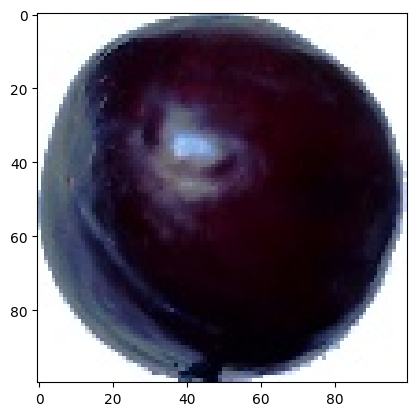

In [13]:
# look at an image for fun
plt.imshow(img_to_array(load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()


### Modelo

Vamos carregar a rede VGG sem as camadas de saida e depois adicionamos essas camadas de acordo com o numero de saidas/classes que desejamos.
Mais camadas podem ser adicionadas e depois verifica-se o impacto nos resultados.

In [14]:

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [15]:
# impedir o treinamento das camadas existentes, congelando os pesos
for layer in vgg.layers:
  layer.trainable = False

In [16]:
# Adicionando as camadas 
x = Flatten()(vgg.output)
#x = Dense(100, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)  # folders definia a quantidade de classes que vão ser usadas

In [17]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [18]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

 - Vamos usar uma opção de de gerador de imagens para termos uma maior variabilidade de dados, DATA AUMENTATION

In [19]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

Found 22688 images belonging to 131 classes.
{'Apple Braeburn': 0, 'Apple Crimson Snow': 1, 'Apple Golden 1': 2, 'Apple Golden 2': 3, 'Apple Golden 3': 4, 'Apple Granny Smith': 5, 'Apple Pink Lady': 6, 'Apple Red 1': 7, 'Apple Red 2': 8, 'Apple Red 3': 9, 'Apple Red Delicious': 10, 'Apple Red Yellow 1': 11, 'Apple Red Yellow 2': 12, 'Apricot': 13, 'Avocado': 14, 'Avocado ripe': 15, 'Banana': 16, 'Banana Lady Finger': 17, 'Banana Red': 18, 'Beetroot': 19, 'Blueberry': 20, 'Cactus fruit': 21, 'Cantaloupe 1': 22, 'Cantaloupe 2': 23, 'Carambula': 24, 'Cauliflower': 25, 'Cherry 1': 26, 'Cherry 2': 27, 'Cherry Rainier': 28, 'Cherry Wax Black': 29, 'Cherry Wax Red': 30, 'Cherry Wax Yellow': 31, 'Chestnut': 32, 'Clementine': 33, 'Cocos': 34, 'Corn': 35, 'Corn Husk': 36, 'Cucumber Ripe': 37, 'Cucumber Ripe 2': 38, 'Dates': 39, 'Eggplant': 40, 'Fig': 41, 'Ginger Root': 42, 'Granadilla': 43, 'Grape Blue': 44, 'Grape Pink': 45, 'Grape White': 46, 'Grape White 2': 47, 'Grape White 3': 48, 'Grape Wh

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -103.831856 max: 151.061


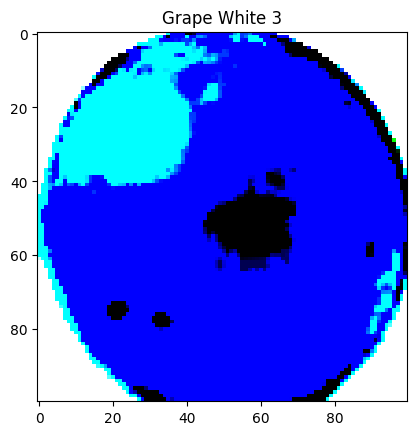

In [20]:
# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [21]:
# Criando geradores para o banco de treinamento e de validação
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


#### treinando o modelo

In [22]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)


Epoch 1/5
2115/2115 [==============================] - 3722s 2s/step - loss: 1.7085 - accuracy: 0.8784 - val_loss: 1.7884 - val_accuracy: 0.9021
Epoch 2/5
2115/2115 [==============================] - 3758s 2s/step - loss: 0.3412 - accuracy: 0.9693 - val_loss: 1.4250 - val_accuracy: 0.9225
Epoch 3/5
2115/2115 [==============================] - 3604s 2s/step - loss: 0.2269 - accuracy: 0.9806 - val_loss: 1.7481 - val_accuracy: 0.9277
Epoch 4/5
2115/2115 [==============================] - 3703s 2s/step - loss: 0.1720 - accuracy: 0.9848 - val_loss: 1.5027 - val_accuracy: 0.9305
Epoch 5/5
2115/2115 [==============================] - 3492s 2s/step - loss: 0.1477 - accuracy: 0.9873 - val_loss: 1.0614 - val_accuracy: 0.9509


#### Testando o modelo

In [23]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break
  cm = confusion_matrix(targets, predictions)
  return cm

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  import itertools
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [25]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 67692
Found 67692 images belonging to 131 classes.
2/2 [==============================] - 2s 1s/step
50
2/2 [==============================] - 2s 1s/step
100
2/2 [==============================] - 2s 1s/step
150
2/2 [==============================] - 2s 1s/step
200
2/2 [==============================] - 2s 1s/step
250
2/2 [==============================] - 2s 1s/step
300
2/2 [==============================] - 2s 1s/step
350
2/2 [==============================] - 2s 1s/step
400
2/2 [==============================] - 2s 1s/step
450
2/2 [==============================] - 2s 1s/step
500
2/2 [==============================] - 2s 1s/step
550
2/2 [==============================] - 2s 1s/step
600
2/2 [==============================] - 2s 1s/step
650
2/2 [==============================] - 2s 1s/step
700
2/2 [==============================] - 2s 1s/step
750
2/2 [==============================] - 2s 1s/step
800
2/2 [==============================] - 2s 1s/step
850
2/2 

In [26]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 22688
Found 22688 images belonging to 131 classes.
2/2 [==============================] - 2s 1s/step
50
2/2 [==============================] - 2s 1s/step
100
2/2 [==============================] - 2s 1s/step
150
2/2 [==============================] - 2s 1s/step
200
2/2 [==============================] - 2s 1s/step
250
2/2 [==============================] - 2s 1s/step
300
2/2 [==============================] - 2s 1s/step
350
1/1 [==============================] - 1s 1s/step
[[113   1   0 ...   0   0   0]
 [  0 135   0 ...   0   0   0]
 [  0   0 158 ...   0   0   0]
 ...
 [  0   0   0 ... 158   0   0]
 [  0   0   0 ...   0 241   0]
 [  0   0   0 ...   0   0 154]]


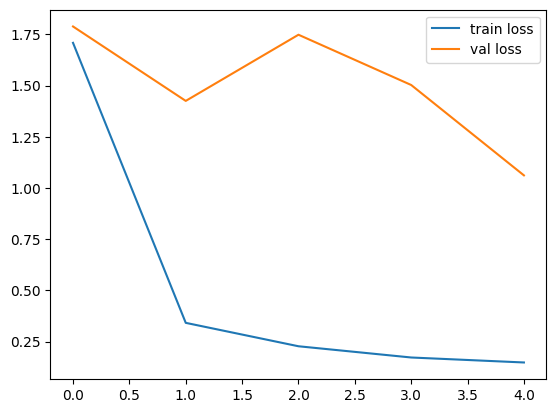

In [27]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

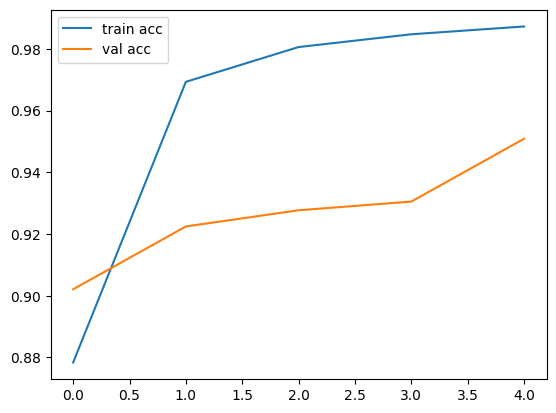

In [28]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


Confusion matrix, without normalization
[[406   3   0 ...   0   0   0]
 [  0 435   0 ...   0   0   0]
 [  0   0 480 ...   0   0   0]
 ...
 [  0   0   0 ... 469   0   0]
 [  0   0   0 ...   0 733   0]
 [  0   0   0 ...   0   0 475]]


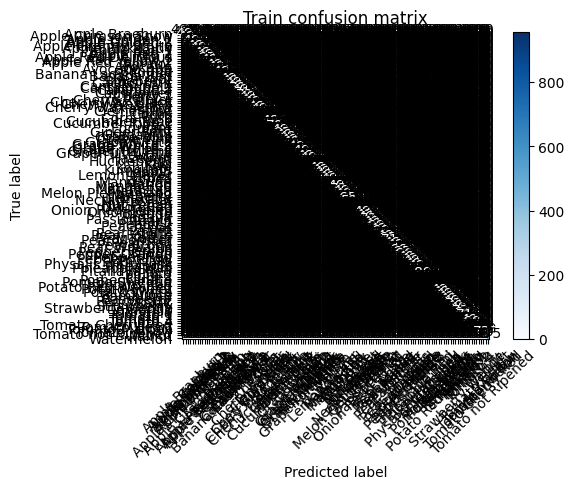

Confusion matrix, without normalization
[[113   1   0 ...   0   0   0]
 [  0 135   0 ...   0   0   0]
 [  0   0 158 ...   0   0   0]
 ...
 [  0   0   0 ... 158   0   0]
 [  0   0   0 ...   0 241   0]
 [  0   0   0 ...   0   0 154]]


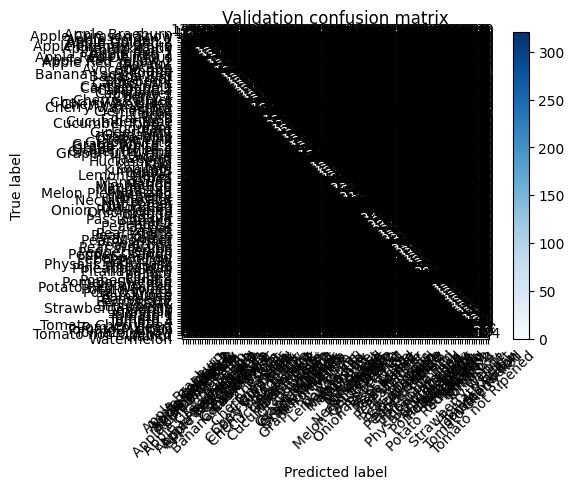

In [29]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')